### Chest X‑ray Multi‑Pathology:

##### **Project goal:** build an unbiased AI diagnostic system for three thoracic pathologies (Atelectasis, Cardiomegaly, Effusion) and ensure consistent performance across demographic groups (age, gender) and imaging protocols (AP/PA).

##### **File structure expected (root):**
##### this notebook
##### `data/` folder containing: `train_split_full.csv`, `val_split_full.csv`, `test_split_full.csv`, `sample_labels.csv`
##### `data/images/` folder containing image files referenced by `Image Index`



### 1- Setup & Installation
##### Run these in your environment if packages aren't installed. In a shared environment, you can uncomment the pip lines.

In [1]:
# !pip install pandas matplotlib seaborn numpy scikit-learn torchvision pillow

### 2- Imports

In [3]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 3- Load CSVs and quick verification

In [4]:
# Paths (adjust if necessary)
ROOT = Path('.')
DATA_DIR = ROOT / 'data'
TRAIN_CSV = DATA_DIR / 'train_split_full.csv'
VAL_CSV = DATA_DIR / 'val_split_full.csv'
TEST_CSV = DATA_DIR / 'test_split_full.csv'
SAMPLE_LABELS = DATA_DIR / 'sample_labels.csv'

for p in [TRAIN_CSV, VAL_CSV, TEST_CSV, SAMPLE_LABELS]:
    print(p, 'exists->', p.exists())

data\train_split_full.csv exists-> True
data\val_split_full.csv exists-> True
data\test_split_full.csv exists-> True
data\sample_labels.csv exists-> True


In [5]:
# Load
train_df = pd.read_csv(TRAIN_CSV)
val_df = pd.read_csv(VAL_CSV)
test_df = pd.read_csv(TEST_CSV)
labels_df = pd.read_csv(SAMPLE_LABELS)

print(f"Train: {train_df.shape}, Val: {val_df.shape}, Test: {test_df.shape}, Labels: {labels_df.shape}")

# Show sample rows
train_df.head(6)

Train: (3884, 16), Val: (578, 16), Test: (1144, 16), Labels: (5606, 11)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,Age_Numeric,Age_Group,Atelectasis,Cardiomegaly,Effusion
0,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168,77.0,>65,0,0,0
1,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143,79.0,>65,1,0,0
2,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168,55.0,40-65,0,1,1
3,00000040_003.png,Consolidation|Mass,3,40,068Y,M,PA,2500,2048,0.168,0.168,68.0,>65,0,0,0
4,00000042_002.png,No Finding,2,42,071Y,M,AP,3056,2544,0.139,0.139,71.0,>65,0,0,0
5,00000061_002.png,Effusion,2,61,077Y,M,PA,2992,2991,0.143,0.143,77.0,>65,0,0,1


#### Verify no patient overlap between splits (patient-wise split)

In [7]:
train_patients = set(train_df['Patient ID'].astype(str).unique())
val_patients = set(val_df['Patient ID'].astype(str).unique())
test_patients = set(test_df['Patient ID'].astype(str).unique())


print(f"Unique patients - train: {len(train_patients)}, val: {len(val_patients)}, test: {len(test_patients)}")


overlap_train_val = train_patients & val_patients
overlap_train_test = train_patients & test_patients
overlap_val_test = val_patients & test_patients


print('Overlaps (should be empty):')
print('train ∩ val:', len(overlap_train_val))
print('train ∩ test:', len(overlap_train_test))
print('val ∩ test:', len(overlap_val_test))


# Assert none overlap (fail loudly if overlap exists)
assert len(overlap_train_val)==0, 'Patient overlap between train and val!'
assert len(overlap_train_test)==0, 'Patient overlap between train and test!'
assert len(overlap_val_test)==0, 'Patient overlap between val and test!'

Unique patients - train: 2961, val: 423, test: 846
Overlaps (should be empty):
train ∩ val: 0
train ∩ test: 0
val ∩ test: 0


#### Basic dataset statistics & pathology prevalence

In [8]:
def dataset_summary(df, name):
    n_images = len(df)
    n_patients = df['Patient ID'].nunique()
    gender_counts = df['Patient Gender'].value_counts(dropna=False).to_dict()
    view_counts = df['View Position'].value_counts(dropna=False).to_dict()
    mean_age = df['Age_Numeric'].mean()
    path_counts = {
        'Atelectasis': int(df['Atelectasis'].sum()),
        'Cardiomegaly': int(df['Cardiomegaly'].sum()),
        'Effusion': int(df['Effusion'].sum())
    }
    return {
        'split': name,
        'n_images': n_images,
        'n_patients': n_patients,
        'gender_counts': gender_counts,
        'view_counts': view_counts,
        'mean_age': mean_age,
        'path_counts': path_counts
    }


summary = [dataset_summary(train_df,'train'), dataset_summary(val_df,'val'), dataset_summary(test_df,'test')]
pd.DataFrame(summary)

,split,n_images,n_patients,gender_counts,view_counts,mean_age,path_counts
0,train,3884,2961,"{'M': 2163, 'F': 1721}","{'PA': 2346, 'AP': 1538}",46.956510,"{'Atelectasis': 368, 'Cardiomegaly': 95, 'Effu..."
1,val,578,423,"{'M': 326, 'F': 252}","{'PA': 358, 'AP': 220}",45.901389,"{'Atelectasis': 55, 'Cardiomegaly': 11, 'Effus..."
2,test,1144,846,"{'M': 645, 'F': 499}","{'PA': 689, 'AP': 455}",46.564685,"{'Atelectasis': 85, 'Cardiomegaly': 35, 'Effus..."


#### Global pathology prevalence (combined)

In [9]:
combined = pd.concat([train_df.assign(split='train'), val_df.assign(split='val'), test_df.assign(split='test')], ignore_index=True)
pathology_cols = ['Atelectasis','Cardiomegaly','Effusion']


for col in pathology_cols:
    total = combined[col].sum()
    pct = total/len(combined)
    print(f"{col}: {int(total)} positive images, {pct:.3%} prevalence")


# Multi-label distribution (counts of images with 0,1,2,3 positives)
combined['label_sum'] = combined[pathology_cols].sum(axis=1)
print('\nLabel cardinality:')
print(combined['label_sum'].value_counts().sort_index())

Atelectasis: 508 positive images, 9.062% prevalence
Cardiomegaly: 141 positive images, 2.515% prevalence
Effusion: 644 positive images, 11.488% prevalence

Label cardinality:
label_sum
0    4527
1     874
2     196
3       9
Name: count, dtype: int64


In [8]:
# Check for missing values:

missing_count = combined.isnull().sum().sort_values(ascending=False)
missing_count



Age_Group                      1
Image Index                    0
Finding Labels                 0
Follow-up #                    0
Patient Age                    0
Patient ID                     0
View Position                  0
OriginalImageWidth             0
OriginalImageHeight            0
Patient Gender                 0
OriginalImagePixelSpacing_x    0
OriginalImagePixelSpacing_y    0
Age_Numeric                    0
Atelectasis                    0
Cardiomegaly                   0
Effusion                       0
split                          0
label_sum                      0
dtype: int64

In [10]:
combined['Age_Group'].unique()

array(['>65', '40-65', '<40', nan], dtype=object)

In [11]:
# Define a function to categorize age
def age_to_group(age):
    if age > 65:
        return '>65'
    elif age >= 40:
        return '40-65'
    else:
        return '<40'

# Fill missing Age_Group
missing_mask = combined['Age_Group'].isnull()
combined.loc[missing_mask, 'Age_Group'] = combined.loc[missing_mask, 'Age_Numeric'].apply(age_to_group)

# Verify
print(combined['Age_Group'].isnull().sum())  # Should be 0 now
combined['Age_Group'].value_counts()

0


Age_Group
40-65    3021
<40      1908
>65       677
Name: count, dtype: int64

#### Where are the biggest class imbalances?
##### We'll produce tables and charts to answer:
##### Absolute counts & prevalence per split
##### Prevalence by Age_Group, Gender, and View Position

In [12]:
# Prevalence per split
split_summary = combined.groupby('split')[pathology_cols].agg(['sum','count'])
# Clean and show prevalence
for col in pathology_cols:
    print('\n--', col)
    for split in ['train','val','test']:
        df_split = combined[combined['split']==split]
        cnt = int(df_split[col].sum())
        pct = cnt / len(df_split)
        print(f"{split}: {cnt} ({pct:.3%})")


-- Atelectasis
train: 368 (9.475%)
val: 55 (9.516%)
test: 85 (7.430%)

-- Cardiomegaly
train: 95 (2.446%)
val: 11 (1.903%)
test: 35 (3.059%)

-- Effusion
train: 451 (11.612%)
val: 64 (11.073%)
test: 129 (11.276%)


### Demographic representation and pathology rates

In [13]:
def prevalence_by(df, group_col):
    # compute prevalence
    prevalence = {}
    for g in df[group_col].fillna('Unknown').unique():
        sub = df[df[group_col].fillna('Unknown')==g]
        n = len(sub)
        row = {col: (int(sub[col].sum()), sub[col].sum()/n if n>0 else np.nan) for col in pathology_cols}
        prevalence[g] = {'n': n, **row}
    return pd.DataFrame.from_dict(prevalence, orient='index')


# By Age_Group
age_prev = prevalence_by(combined, 'Age_Group')
age_prev_sorted = age_prev.sort_index()

# By Gender
gender_prev = prevalence_by(combined, 'Patient Gender')

# By View Position
view_prev = prevalence_by(combined, 'View Position')

# Display concise tables
print(age_prev_sorted)
print('\nPrevalence by Age_Group (top rows)')
print(age_prev_sorted.head(10))

print('\nPrevalence by Gender')
print(gender_prev)

print('\nPrevalence by View Position')
print(view_prev)

          n                 Atelectasis                Cardiomegaly  \
40-65  3021  (324, 0.10724925521350546)  (71, 0.023502151605428664)   
<40    1908  (112, 0.05870020964360587)   (50, 0.02620545073375262)   
>65     677   (72, 0.10635155096011817)  (20, 0.029542097488921712)   

                         Effusion  
40-65  (365, 0.12082092022509103)  
<40    (173, 0.09067085953878407)  
>65    (106, 0.15657311669128507)  

Prevalence by Age_Group (top rows)
          n                 Atelectasis                Cardiomegaly  \
40-65  3021  (324, 0.10724925521350546)  (71, 0.023502151605428664)   
<40    1908  (112, 0.05870020964360587)   (50, 0.02620545073375262)   
>65     677   (72, 0.10635155096011817)  (20, 0.029542097488921712)   

                         Effusion  
40-65  (365, 0.12082092022509103)  
<40    (173, 0.09067085953878407)  
>65    (106, 0.15657311669128507)  

Prevalence by Gender
      n                 Atelectasis               Cardiomegaly  \
M  3134  (321, 0.1

#### Visualizations
##### We'll create the following plots:
##### - Pathology prevalence bar chart (overall)
##### - Prevalence by Age_Group (stacked or grouped bar)
##### - Prevalence by Gender
##### - Prevalence by View Position (AP vs PA)
##### - Heatmap of pathology co-occurrence

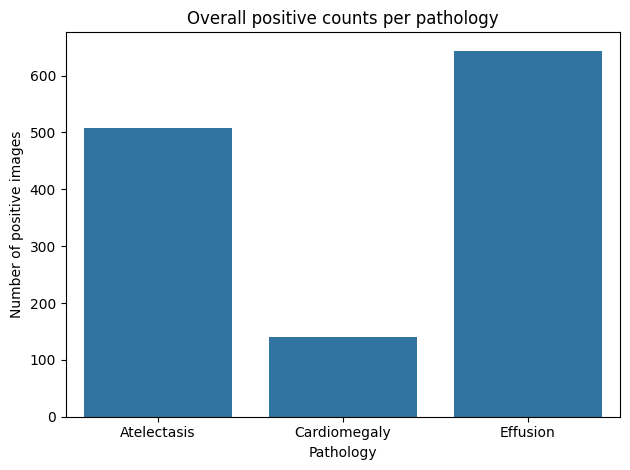

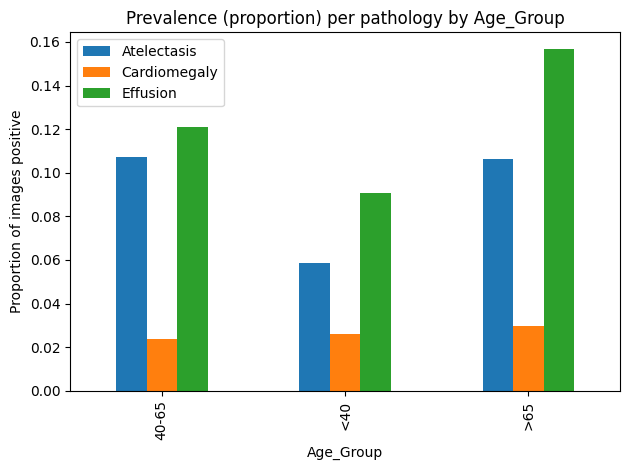

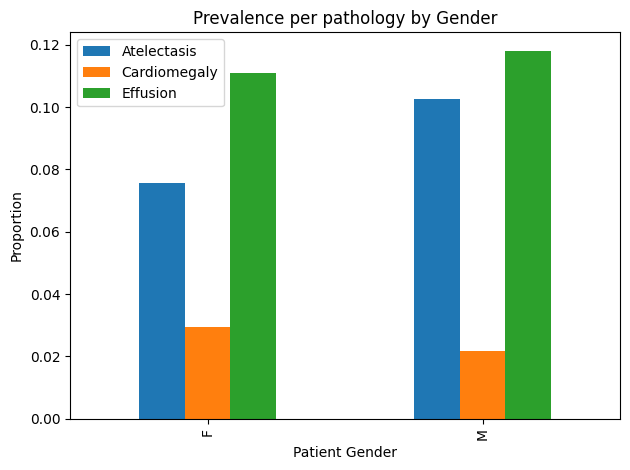

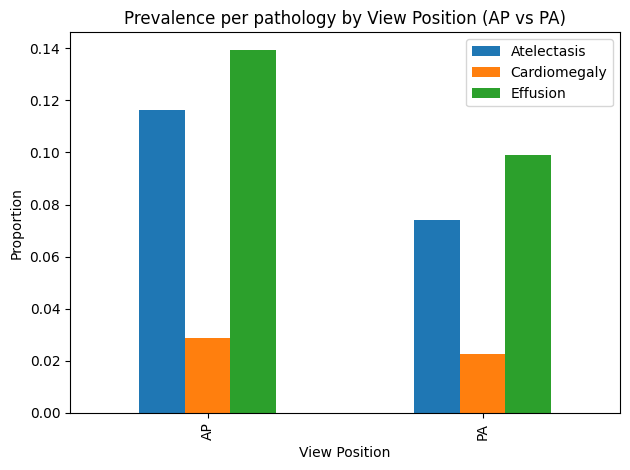

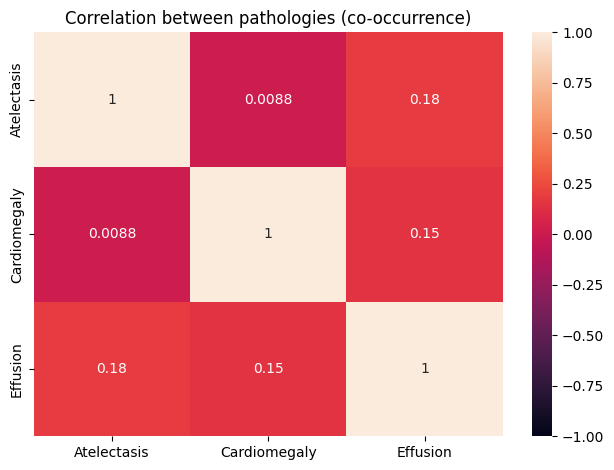

In [14]:
# Overall prevalence
plt.figure()
counts = [combined[col].sum() for col in pathology_cols]
sns.barplot(x=pathology_cols, y=counts)
plt.title('Overall positive counts per pathology')
plt.ylabel('Number of positive images')
plt.xlabel('Pathology')
plt.tight_layout()
plt.show()


# Prevalence by Age_Group
age_groups = combined['Age_Group'].fillna('Unknown').unique()
age_groups = sorted(age_groups, key=lambda x: (str(x)))
age_group_df = combined.groupby('Age_Group')[pathology_cols].mean().loc[age_groups]
age_group_df.plot(kind='bar')
plt.title('Prevalence (proportion) per pathology by Age_Group')
plt.ylabel('Proportion of images positive')
plt.tight_layout()
plt.show()


# Prevalence by Gender
gender_df = combined.groupby('Patient Gender')[pathology_cols].mean()
gender_df.plot(kind='bar')
plt.title('Prevalence per pathology by Gender')
plt.ylabel('Proportion')
plt.tight_layout()
plt.show()


# Prevalence by View Position
view_df = combined.groupby('View Position')[pathology_cols].mean()
view_df.plot(kind='bar')
plt.title('Prevalence per pathology by View Position (AP vs PA)')
plt.ylabel('Proportion')
plt.tight_layout()
plt.show()


# Co-occurrence heatmap
cooc = combined[pathology_cols].corr()
sns.heatmap(cooc, annot=True, vmin=-1, vmax=1)
plt.title('Correlation between pathologies (co-occurrence)')
plt.tight_layout()
plt.show()

### 2. Data Preprocessing for Chest X-Ray Multi-Pathology Classification

#### A. Data Validation

##### Check for corrupted images

In [16]:
from PIL import Image
import os

def check_images(image_dir, image_list):
    corrupted = []
    for img_name in image_list:
        img_path = os.path.join(image_dir, img_name)
        try:
            with Image.open(img_path) as im:
                im.verify()  # check for corruption
        except Exception as e:
            corrupted.append(img_name)
    return corrupted

corrupted_train = check_images('data/images', combined['Image Index'])
print(f"Corrupted images: {corrupted_train}")

Corrupted images: []


In [17]:
# Confirm pathology columns are numeric and no missing values
print(combined[pathology_cols].isnull().sum())

print(combined['OriginalImageWidth'].describe())
print(combined['OriginalImageHeight'].describe())
print(combined['View Position'].value_counts())

Atelectasis     0
Cardiomegaly    0
Effusion        0
dtype: int64
count    5606.000000
mean     2644.795755
std       347.188754
min      1362.000000
25%      2500.000000
50%      2542.000000
75%      2992.000000
max      3266.000000
Name: OriginalImageWidth, dtype: float64
count    5606.000000
mean     2491.087406
std       399.119063
min       966.000000
25%      2048.000000
50%      2544.000000
75%      2991.000000
max      3056.000000
Name: OriginalImageHeight, dtype: float64
View Position
PA    3393
AP    2213
Name: count, dtype: int64


#### B. Medical Imaging Preprocessing

1. Standardize dimensions
2. Normalize pixel values
3. Data Imbalance Handling
4. Pipeline Development

In [18]:
import os
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from PIL import Image
from torchvision import transforms
from math import ceil

# ============================
# 1. Define paths + pathology labels
# ============================

image_dir = "data/images"
pathology_cols = ["Atelectasis", "Cardiomegaly", "Effusion"]

# Load splits
train_df = pd.read_csv(TRAIN_CSV)
val_df   = pd.read_csv(VAL_CSV)
test_df  = pd.read_csv(TEST_CSV)

# ============================
# 2. Preprocessing transforms
# ============================

# Standard preprocessing (no augmentation)
standard_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3,1,1)),  # repeat to 3 channels
    transforms.Normalize([0.5]*3, [0.5]*3)
])

augment_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3,1,1)),  # repeat to 3 channels
    transforms.Normalize([0.5]*3, [0.5]*3)
])


# ============================
# 3. Compute class prevalence ONCE (efficient)
# ============================

def compute_prevalence(df, pathology_cols):
    prevalence = {col: df[col].mean() for col in pathology_cols}
    return prevalence

train_prevalence = compute_prevalence(train_df, pathology_cols)


# ============================
# 4. Dataset class (train supports augmentation)
# ============================

class ChestXRayDataset(Dataset):
    def __init__(self, df, pathology_cols, transform, augment_transform=None, prevalence=None):
        """
        df: dataframe for split
        transform: standard transform
        augment_transform: only used for training
        prevalence: dictionary of class prevalence (only for training)
        """
        self.df = df.reset_index(drop=True)
        self.pathology_cols = pathology_cols
        self.transform = transform
        self.augment_transform = augment_transform
        self.prevalence = prevalence  # None for val/test

        # Ensure labels are numeric (0/1 floats)
        for col in pathology_cols:
            self.df[col] = pd.to_numeric(self.df[col], errors="coerce").fillna(0).astype(float)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load image
        img_path = os.path.join(image_dir, row["Image Index"])
        img = Image.open(img_path).convert("L")

        # Handle labels
        labels_array = row[self.pathology_cols].to_numpy(dtype=float)
        labels = torch.tensor(labels_array, dtype=torch.float32)

        # Apply standard transform for val/test
        if self.prevalence is None:
            img_tensor = self.transform(img)
            return img_tensor, labels

        # ============================
        # Training: apply augmentation based on class rarity
        # ============================
        is_minority = any(
            (row[col] == 1) and (self.prevalence[col] < 0.10)
            for col in self.pathology_cols
        )

        if is_minority:
            img_tensor = self.augment_transform(img)
        else:
            img_tensor = self.transform(img)

        return img_tensor, labels


# ============================
# 5. WeightedRandomSampler (for training only)
# ============================

def create_equalized_sampler(df, pathology_cols, p_target=0.10, max_weight=50.0):
    """
    Returns a WeightedRandomSampler that pushes each pathology toward p_target prevalence
    (in expectation) during training.
    """
    total = len(df)
    # current prevalences p_c
    p = {col: (df[col].mean() if df[col].mean() > 0 else 1e-6) for col in pathology_cols}

    weights = []
    for _, row in df.iterrows():
        w = 1.0
        for col in pathology_cols:
            if row[col] == 1:
                w *= (p_target / p[col])
        w = min(w, max_weight)  # prevent extreme domination
        weights.append(float(w))

    return WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

def estimate_sampler_prevalences(df, pathology_cols, sampler, n_samples=5000):
    """
    Estimates expected label prevalences from a sampler by drawing n_samples
    and counting how often each pathology appears.
    """
    print("\n--- Sampler Prevalence Diagnostic ---")
    print(f"Sampling {n_samples} virtual samples...")

    # Since sampler returns indices, we convert to list once
    sampled_indices = list(sampler)

    # If n_samples < dataset size, randomly pick subset for speed
    if n_samples < len(sampled_indices):
        sampled_indices = np.random.choice(sampled_indices, n_samples, replace=True)

    counts = {col: 0 for col in pathology_cols}

    for idx in sampled_indices:
        row = df.iloc[int(idx)]
        for col in pathology_cols:
            counts[col] += int(row[col])

    # Convert to percentages
    prevalences = {col: counts[col] / len(sampled_indices) for col in pathology_cols}

    print("Estimated per-epoch prevalences:")
    for col in pathology_cols:
        print(f"  {col}: {prevalences[col] * 100:.2f}%")

    return prevalences

# ============================
# 6. Create datasets
# ============================

train_dataset = ChestXRayDataset(
    train_df,
    pathology_cols,
    transform=standard_transform,
    augment_transform=augment_transform,
    prevalence=train_prevalence   # enables augmentation logic
)

val_dataset = ChestXRayDataset(
    val_df,
    pathology_cols,
    transform=standard_transform,
    augment_transform=None,
    prevalence=None               # disables augmentation
)

test_dataset = ChestXRayDataset(
    test_df,
    pathology_cols,
    transform=standard_transform,
    augment_transform=None,
    prevalence=None
)

# ============================
# 7. DataLoaders
# ============================

train_sampler = create_equalized_sampler(train_df, pathology_cols, p_target=0.12, max_weight=20.0)

train_loader = DataLoader(train_dataset, batch_size=16, sampler=train_sampler)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

# ============================
# 8. Test example
# ============================

for images, labels in train_loader:
    print("Train batch:", images.shape, labels.shape)
    break

estimate_sampler_prevalences(train_df, pathology_cols, train_sampler, n_samples=5000)



Train batch: torch.Size([16, 3, 256, 256]) torch.Size([16, 3])

--- Sampler Prevalence Diagnostic ---
Sampling 5000 virtual samples...
Estimated per-epoch prevalences:
  Atelectasis: 12.38%
  Cardiomegaly: 11.28%
  Effusion: 15.04%


{'Atelectasis': 0.12384140061791966,
 'Cardiomegaly': 0.11277033985581875,
 'Effusion': 0.15036045314109167}

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
import numpy as np

# Load pre-trained DenseNet-121
densenet = models.densenet121(pretrained=True)

# Check the final classifier
print(densenet.classifier)
# Typically: Linear(in_features=1024, out_features=1000, bias=True)

Linear(in_features=1024, out_features=1000, bias=True)


c:\Users\youss\OneDrive\Desktop\GUC\Semester 9\AiR\AiR-Fairness-in-Multi-modal-Chest-X-Ray-Diagnosis\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\youss\OneDrive\Desktop\GUC\Semester 9\AiR\AiR-Fairness-in-Multi-modal-Chest-X-Ray-Diagnosis\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
num_features = densenet.classifier.in_features
densenet.classifier = nn.Linear(num_features, 3)  # 3 pathologies

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
densenet = densenet.to(device)

# Freeze all layers except the classifier
for param in densenet.features.parameters():
    param.requires_grad = False


In [19]:
# --- 2. Loss with pos_weight ---
train_labels = train_df[pathology_cols].values
pos_weight = torch.tensor(
    [(len(train_labels) - train_labels[:, i].sum()) / (train_labels[:, i].sum() + 1e-6)
     for i in range(len(pathology_cols))],
    dtype=torch.float32
).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# --- 3. Optimizer ---
optimizer = optim.Adam(densenet.classifier.parameters(), lr=1e-3)

In [20]:
# --- 4. Training loop ---
num_epochs = 5  # adjust as needed

for epoch in range(num_epochs):
    densenet.train()
    train_loss = 0.0

    for batch_idx, (images, labels) in enumerate(train_loader, 1):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = densenet(images)  # logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{batch_idx}/{len(train_loader)}] Loss: {loss.item():.4f}")


    avg_train_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}")

    # --- 5. Validation metrics ---
    densenet.eval()
    val_labels_list, val_preds_list = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = densenet(images)
            probs = torch.sigmoid(outputs)
            val_labels_list.append(labels.cpu().numpy())
            val_preds_list.append(probs.cpu().numpy())

    val_labels_arr = np.vstack(val_labels_list)
    val_preds_arr = np.vstack(val_preds_list)

    # Overall AUC per pathology
    print("Validation AUCs:")
    for i, col in enumerate(pathology_cols):
        auc = roc_auc_score(val_labels_arr[:, i], val_preds_arr[:, i])
        print(f"  {col}: {auc:.4f}")

    # Precision, Recall, F1 (threshold=0.5)
    precision, recall, f1, _ = precision_recall_fscore_support(
        val_labels_arr, val_preds_arr>0.5, average=None
    )
    for i, col in enumerate(pathology_cols):
        print(f"  {col} - Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1: {f1[i]:.4f}")

    # --- 6. Subgroup Analysis ---
    for group_col in ['Age_Group', 'Patient Gender', 'View Position']:
        print(f"\nSubgroup metrics by {group_col}:")
        for group_val in val_df[group_col].unique():
            mask = val_df[group_col] == group_val
            y_true_group = val_labels_arr[mask.values]
            y_pred_group = val_preds_arr[mask.values]
            if len(y_true_group) == 0:
                continue
            for i, col in enumerate(pathology_cols):
                auc = roc_auc_score(y_true_group[:, i], y_pred_group[:, i])
                print(f"  {group_val}, {col} AUC={auc:.4f}")

# --- 7. Save baseline model ---
torch.save(densenet.state_dict(), "densenet_feature_baseline.pth")

Epoch [1/5] Batch [1/243] Loss: 1.7366
Epoch [1/5] Batch [2/243] Loss: 1.9220
Epoch [1/5] Batch [3/243] Loss: 2.6132
Epoch [1/5] Batch [4/243] Loss: 1.3240
Epoch [1/5] Batch [5/243] Loss: 1.2942
Epoch [1/5] Batch [6/243] Loss: 2.1257
Epoch [1/5] Batch [7/243] Loss: 1.7538
Epoch [1/5] Batch [8/243] Loss: 1.7699
Epoch [1/5] Batch [9/243] Loss: 2.0230
Epoch [1/5] Batch [10/243] Loss: 1.4768
Epoch [1/5] Batch [11/243] Loss: 1.5091
Epoch [1/5] Batch [12/243] Loss: 1.6189
Epoch [1/5] Batch [13/243] Loss: 1.9092
Epoch [1/5] Batch [14/243] Loss: 1.6616
Epoch [1/5] Batch [15/243] Loss: 1.7181
Epoch [1/5] Batch [16/243] Loss: 1.6691
Epoch [1/5] Batch [17/243] Loss: 1.6076
Epoch [1/5] Batch [18/243] Loss: 1.4658
Epoch [1/5] Batch [19/243] Loss: 1.7878
Epoch [1/5] Batch [20/243] Loss: 1.4298
Epoch [1/5] Batch [21/243] Loss: 1.5156
Epoch [1/5] Batch [22/243] Loss: 1.5402
Epoch [1/5] Batch [23/243] Loss: 1.5912
Epoch [1/5] Batch [24/243] Loss: 1.3783
Epoch [1/5] Batch [25/243] Loss: 1.7623
Epoch [1/

In [21]:
import torch
import torch.nn as nn
from torchvision import models

# Load pretrained DenseNet-121
densenet = models.densenet121(pretrained=True)

# Modify classifier for 3 pathologies
num_features = densenet.classifier.in_features
densenet.classifier = nn.Linear(num_features, 3)

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
densenet = densenet.to(device)

# Optional: small weight initialization for classifier
nn.init.xavier_uniform_(densenet.classifier.weight)


c:\Users\youss\OneDrive\Desktop\GUC\Semester 9\AiR\AiR-Fairness-in-Multi-modal-Chest-X-Ray-Diagnosis\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\youss\OneDrive\Desktop\GUC\Semester 9\AiR\AiR-Fairness-in-Multi-modal-Chest-X-Ray-Diagnosis\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Parameter containing:
tensor([[-0.0178, -0.0139, -0.0426,  ..., -0.0005,  0.0251, -0.0618],
        [-0.0316, -0.0524, -0.0245,  ..., -0.0309, -0.0320, -0.0287],
        [-0.0441, -0.0582, -0.0025,  ..., -0.0154, -0.0716,  0.0598]],
       requires_grad=True)

In [23]:
import torch.optim as optim
import numpy as np

# Compute pos_weight from training set prevalence
train_labels = train_df[pathology_cols].values
pos_weight = torch.tensor(
    [(len(train_labels) - train_labels[:, i].sum()) / (train_labels[:, i].sum() + 1e-6)
     for i in range(len(pathology_cols))], dtype=torch.float32
).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Optimizer: train all parameters
optimizer = optim.Adam(densenet.parameters(), lr=1e-4, weight_decay=1e-5)


In [23]:
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support

num_epochs = 10  # fine-tuning usually needs more epochs
train_loader = train_loader  # from your preprocessing pipeline
val_loader = val_loader

for epoch in range(num_epochs):
    densenet.train()
    running_loss = 0.0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = densenet(images)  # logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        if (batch_idx + 1) % 20 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{batch_idx+1}/{len(train_loader)}] Loss: {loss.item():.4f}")

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f}")

    # --- Validation ---
    densenet.eval()
    val_labels_list, val_preds_list = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = densenet(images)
            probs = torch.sigmoid(outputs)
            val_labels_list.append(labels.cpu().numpy())
            val_preds_list.append(probs.cpu().numpy())

    val_labels_arr = np.vstack(val_labels_list)
    val_preds_arr = np.vstack(val_preds_list)

    # --- Overall metrics per pathology ---
    print("Validation AUCs:")
    for i, col in enumerate(pathology_cols):
        auc = roc_auc_score(val_labels_arr[:, i], val_preds_arr[:, i])
        precision, recall, f1, _ = precision_recall_fscore_support(
            val_labels_arr[:, i], (val_preds_arr[:, i] > 0.5).astype(int), zero_division=0
        )
        print(f"  {col}: AUC={auc:.4f}, Precision={precision[1]:.4f}, Recall={recall[1]:.4f}, F1={f1[1]:.4f}")


Epoch [1/10] Batch [20/243] Loss: 1.5910
Epoch [1/10] Batch [40/243] Loss: 1.1435
Epoch [1/10] Batch [60/243] Loss: 0.8475
Epoch [1/10] Batch [80/243] Loss: 0.7071
Epoch [1/10] Batch [100/243] Loss: 0.9065
Epoch [1/10] Batch [120/243] Loss: 0.4653
Epoch [1/10] Batch [140/243] Loss: 0.9216
Epoch [1/10] Batch [160/243] Loss: 0.5216
Epoch [1/10] Batch [180/243] Loss: 0.5975
Epoch [1/10] Batch [200/243] Loss: 0.5367
Epoch [1/10] Batch [220/243] Loss: 0.7461
Epoch [1/10] Batch [240/243] Loss: 0.7027
Epoch 1/10 - Train Loss: 0.8292
Validation AUCs:
  Atelectasis: AUC=0.6260, Precision=0.0000, Recall=0.0000, F1=0.0000
  Cardiomegaly: AUC=0.5714, Precision=0.0000, Recall=0.0000, F1=0.0000
  Effusion: AUC=0.7233, Precision=0.2236, Recall=0.5625, F1=0.3200
Epoch [2/10] Batch [20/243] Loss: 0.4847
Epoch [2/10] Batch [40/243] Loss: 0.4549
Epoch [2/10] Batch [60/243] Loss: 1.1807
Epoch [2/10] Batch [80/243] Loss: 0.3733
Epoch [2/10] Batch [100/243] Loss: 0.4579
Epoch [2/10] Batch [120/243] Loss: 0.

In [25]:
torch.save({
    'model_state_dict': densenet.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch  # optional, to know which epoch you stopped at
}, "densenet_finetuned.pth")

In [24]:
import torch
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load("densenet_finetuned.pth", map_location=device)

# Load model and optimizer states
densenet.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


densenet.eval()

y_true_list = []
y_score_list = []   # sigmoid probabilities

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        logits = densenet(images)                 # (B, 3)
        probs  = torch.sigmoid(logits)         # (B, 3)

        y_true_list.append(labels.cpu().numpy())
        y_score_list.append(probs.cpu().numpy())

y_true = np.vstack(y_true_list)   # shape (N, 3)
y_score = np.vstack(y_score_list) # shape (N, 3)

# If your test_loader was created with shuffle=False (recommended),
# the order matches test_df (after reset_index).
test_meta = test_df.reset_index(drop=True)
assert len(test_meta) == len(y_true), "Mismatch: test_df length != number of test predictions"

In [26]:
threshold = 0.3
y_pred = (y_score >= threshold).astype(int)

overall_rows = []
for i, col in enumerate(pathology_cols):
    auc = roc_auc_score(y_true[:, i], y_score[:, i])

    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true[:, i], y_pred[:, i], average='binary', zero_division=0
    )

    overall_rows.append({
        "pathology": col,
        "AUC_ROC": auc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1
    })

overall_df = pd.DataFrame(overall_rows)
print("\n=== OVERALL PERFORMANCE (threshold=0.3) ===")
print(overall_df.to_string(index=False))




=== OVERALL PERFORMANCE (threshold=0.3) ===
   pathology  AUC_ROC  Precision   Recall       F1
 Atelectasis 0.635761   0.250000 0.011765 0.022472
Cardiomegaly 0.808579   0.200000 0.171429 0.184615
    Effusion 0.766182   0.327189 0.550388 0.410405


In [27]:
# Subgroup analysis
def metrics_per_group(meta_df, y_true, y_score, group_col, threshold=0.5):
    results = []
    y_pred = (y_score >= threshold).astype(int)

    for group in meta_df[group_col].dropna().unique():
        mask = (meta_df[group_col] == group).to_numpy()
        if mask.sum() == 0:
            continue

        for i, col in enumerate(pathology_cols):
            auc = roc_auc_score(y_true[mask, i], y_score[mask, i])

            prec, rec, f1, _ = precision_recall_fscore_support(
                y_true[mask, i], y_pred[mask, i], average='binary', zero_division=0
            )

            results.append({
                "group_col": group_col,
                "group_val": group,
                "pathology": col,
                "n": int(mask.sum()),
                "AUC_ROC": auc,
                "Precision": prec,
                "Recall": rec,
                "F1": f1
            })

    return pd.DataFrame(results)

subgroup_age   = metrics_per_group(test_meta, y_true, y_score, "Age_Group", threshold=0.5)
subgroup_gender= metrics_per_group(test_meta, y_true, y_score, "Patient Gender", threshold=0.5)
subgroup_view  = metrics_per_group(test_meta, y_true, y_score, "View Position", threshold=0.5)

print("\n=== SUBGROUP PERFORMANCE: Age_Group ===")
print(subgroup_age.to_string(index=False))

print("\n=== SUBGROUP PERFORMANCE: Patient Gender ===")
print(subgroup_gender.to_string(index=False))

print("\n=== SUBGROUP PERFORMANCE: View Position ===")
print(subgroup_view.to_string(index=False))



=== SUBGROUP PERFORMANCE: Age_Group ===
group_col group_val    pathology   n  AUC_ROC  Precision   Recall       F1
Age_Group       >65  Atelectasis 143 0.597633   0.000000 0.000000 0.000000
Age_Group       >65 Cardiomegaly 143 0.652174   0.250000 0.200000 0.222222
Age_Group       >65     Effusion 143 0.779348   0.310345 0.391304 0.346154
Age_Group     40-65  Atelectasis 602 0.627023   1.000000 0.018182 0.035714
Age_Group     40-65 Cardiomegaly 602 0.861285   0.250000 0.090909 0.133333
Age_Group     40-65     Effusion 602 0.781918   0.372340 0.486111 0.421687
Age_Group       <40  Atelectasis 399 0.608254   0.000000 0.000000 0.000000
Age_Group       <40 Cardiomegaly 399 0.767583   0.000000 0.000000 0.000000
Age_Group       <40     Effusion 399 0.700161   0.340909 0.441176 0.384615

=== SUBGROUP PERFORMANCE: Patient Gender ===
     group_col group_val    pathology   n  AUC_ROC  Precision   Recall       F1
Patient Gender         M  Atelectasis 645 0.688198   1.000000 0.020833 0.040816
Pat

In [28]:
def fairness_gap(subgroup_df, metric="AUC_ROC"):
    gaps = []
    for col in pathology_cols:
        df = subgroup_df[subgroup_df["pathology"] == col]
        if df.empty:
            continue
        m_max = df[metric].max()
        m_min = df[metric].min()
        gaps.append({
            "metric": metric,
            "pathology": col,
            "max_val": float(m_max),
            "min_val": float(m_min),
            "gap (max-min)": float(m_max - m_min),
            "best_group": df.loc[df[metric].idxmax(), "group_val"],
            "worst_group": df.loc[df[metric].idxmin(), "group_val"],
        })
    return pd.DataFrame(gaps)

print("\n=== FAIRNESS GAPS (AUC-ROC) ===")
print(fairness_gap(subgroup_age, "AUC_ROC").to_string(index=False))
print(fairness_gap(subgroup_gender, "AUC_ROC").to_string(index=False))
print(fairness_gap(subgroup_view, "AUC_ROC").to_string(index=False))



=== FAIRNESS GAPS (AUC-ROC) ===
 metric    pathology  max_val  min_val  gap (max-min) best_group worst_group
AUC_ROC  Atelectasis 0.627023 0.597633       0.029390      40-65         >65
AUC_ROC Cardiomegaly 0.861285 0.652174       0.209111      40-65         >65
AUC_ROC     Effusion 0.781918 0.700161       0.081757      40-65         <40
 metric    pathology  max_val  min_val  gap (max-min) best_group worst_group
AUC_ROC  Atelectasis 0.688198 0.568855       0.119343          M           F
AUC_ROC Cardiomegaly 0.808960 0.801240       0.007720          M           F
AUC_ROC     Effusion 0.815122 0.717905       0.097218          F           M
 metric    pathology  max_val  min_val  gap (max-min) best_group worst_group
AUC_ROC  Atelectasis 0.648787 0.601695       0.047092         PA          AP
AUC_ROC Cardiomegaly 0.816857 0.798550       0.018308         PA          AP
AUC_ROC     Effusion 0.789452 0.731089       0.058363         PA          AP


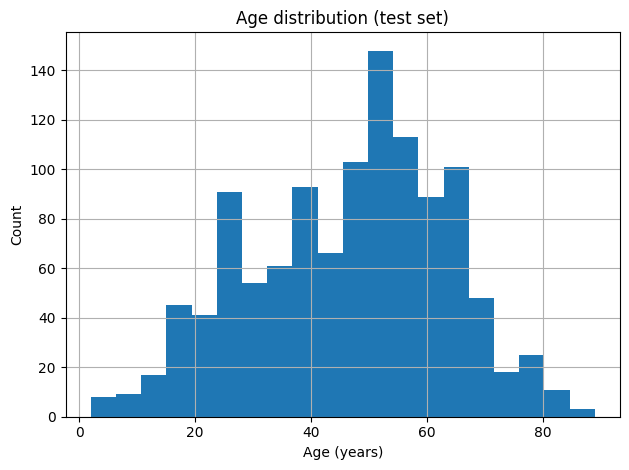

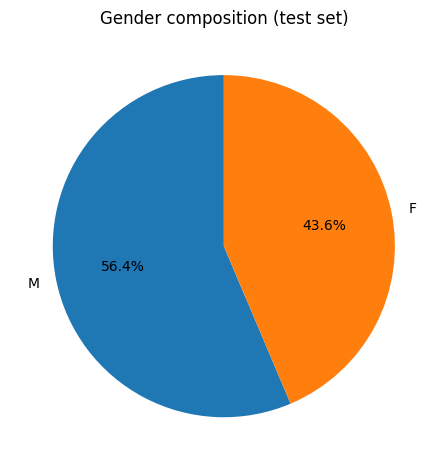

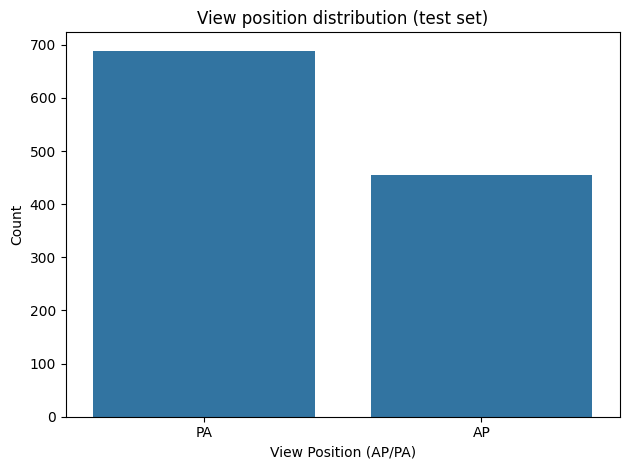

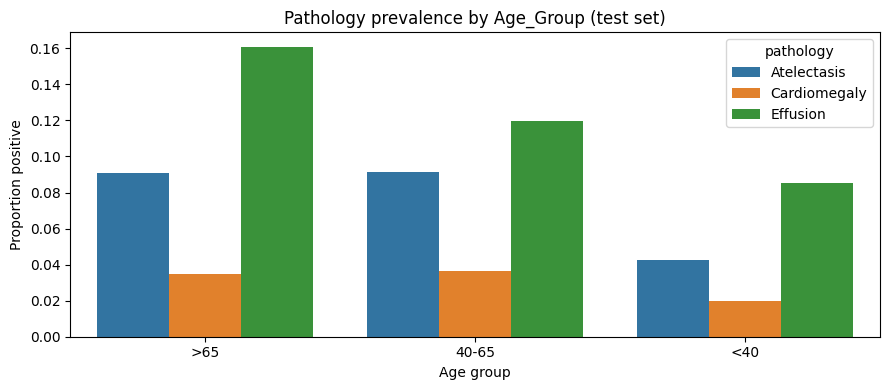

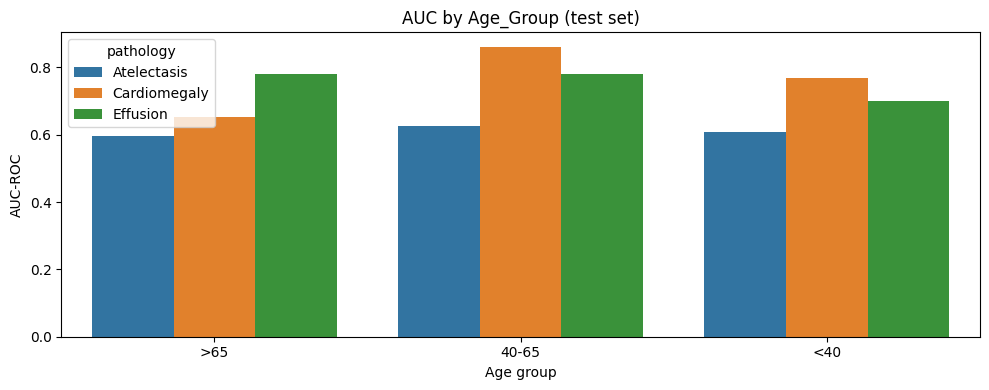

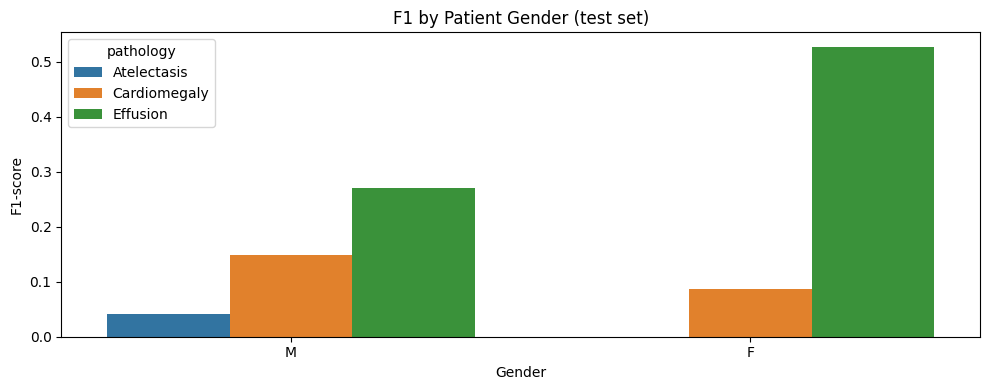

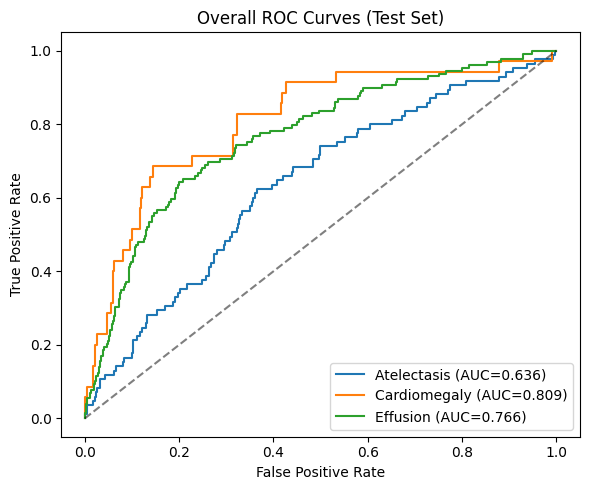

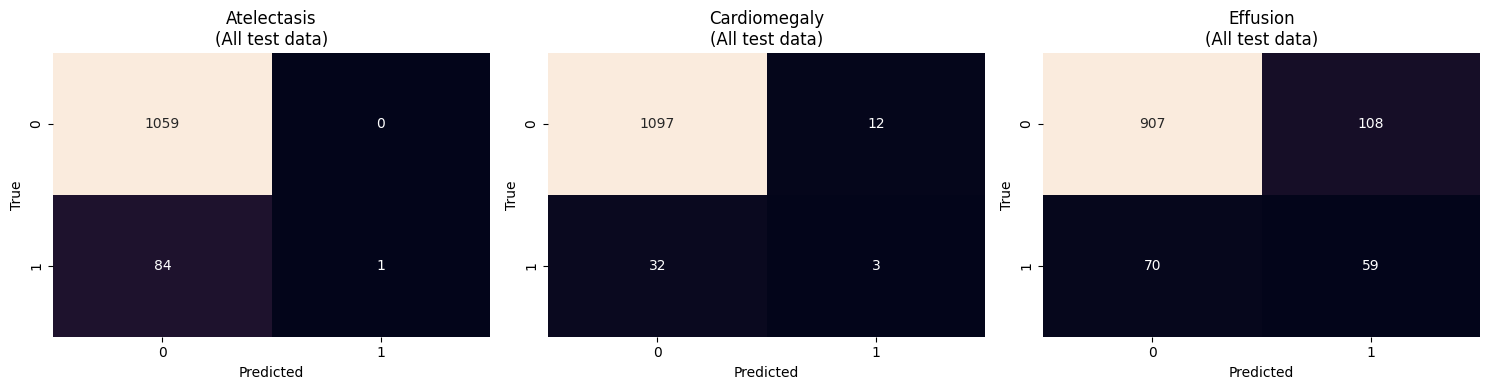

In [29]:
# =========================
# VISUALIZATION SUITE (after inference)
# Assumes: y_true (N,3), y_score (N,3), test_meta (N rows), pathology_cols defined
# Model: densenet (trained), device set
# =========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score, precision_recall_fscore_support

# -------------------------
# 0) Helper: binarize predictions (you can change threshold)
# -------------------------
DEFAULT_THRESH = 0.5

def binarize(y_prob, thresh=DEFAULT_THRESH):
    return (y_prob >= thresh).astype(int)

y_pred = binarize(y_score, DEFAULT_THRESH)

# =========================
# 1) DEMOGRAPHIC ANALYSIS PLOTS
# =========================

# (1) Age distribution (using Age_Numeric)
plt.figure()
test_meta['Age_Numeric'].dropna().astype(float).hist(bins=20)
plt.title("Age distribution (test set)")
plt.xlabel("Age (years)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# (2) Gender balance (pie)
plt.figure()
gender_counts = test_meta['Patient Gender'].value_counts(dropna=False)
gender_counts.plot.pie(autopct='%1.1f%%', startangle=90)
plt.title("Gender composition (test set)")
plt.ylabel("")
plt.tight_layout()
plt.show()

# (3) View position distribution (bar)
plt.figure()
view_counts = test_meta['View Position'].value_counts(dropna=False)
sns.barplot(x=view_counts.index, y=view_counts.values)
plt.title("View position distribution (test set)")
plt.ylabel("Count")
plt.xlabel("View Position (AP/PA)")
plt.tight_layout()
plt.show()

# (4) Comorbidity prevalence across age groups (who has which pathology)
# (This is a useful fairness-adjacent demographic view.)
def prevalence_table_by_group(meta, y_true, group_col):
    df = meta[[group_col]].copy()
    df['group'] = df[group_col].astype(str)
    out = []
    for g in df['group'].unique():
        mask = (df['group'] == g).values
        n = mask.sum()
        if n == 0: 
            continue
        for j, p in enumerate(pathology_cols):
            prev = y_true[mask, j].mean()
            out.append({"group": g, "pathology": p, "prevalence": prev, "n": int(n)})
    return pd.DataFrame(out)

prev_age = prevalence_table_by_group(test_meta, y_true, "Age_Group")
plt.figure(figsize=(9,4))
sns.barplot(data=prev_age, x="group", y="prevalence", hue="pathology")
plt.title("Pathology prevalence by Age_Group (test set)")
plt.ylabel("Proportion positive")
plt.xlabel("Age group")
plt.tight_layout()
plt.show()

# =========================
# 2) PERFORMANCE COMPARISON ACROSS SUBGROUPS (AUC + F1)
# =========================

def metrics_table(meta, y_true, y_score, group_col=None, threshold=DEFAULT_THRESH):
    """
    Returns a long-form dataframe:
    group_col | group_val | pathology | AUC | F1 | Precision | Recall | n
    """
    rows = []
    if group_col is None:
        groups = [("ALL", None)]
    else:
        groups = [(str(v), (meta[group_col] == v).values) for v in meta[group_col].dropna().unique()]

    for gname, mask in groups:
        if mask is None:
            mask = np.ones(len(meta), dtype=bool)

        for j, p in enumerate(pathology_cols):
            if mask.sum() < 2:
                continue
            auc_val = roc_auc_score(y_true[mask, j], y_score[mask, j])
            yhat = (y_score[mask, j] >= threshold).astype(int)
            prec, rec, f1, _ = precision_recall_fscore_support(
                y_true[mask, j], yhat, average='binary', zero_division=0
            )
            rows.append({
                "group_col": group_col or "ALL",
                "group_val": gname,
                "pathology": p,
                "AUC": auc_val,
                "F1": f1,
                "Precision": prec,
                "Recall": rec,
                "n": int(mask.sum())
            })
    return pd.DataFrame(rows)

overall_metrics = metrics_table(test_meta, y_true, y_score, group_col=None)
age_metrics     = metrics_table(test_meta, y_true, y_score, group_col="Age_Group")
gender_metrics  = metrics_table(test_meta, y_true, y_score, group_col="Patient Gender")
view_metrics    = metrics_table(test_meta, y_true, y_score, group_col="View Position")

# Example: AUC comparison by age (bar chart)
plt.figure(figsize=(10,4))
sns.barplot(data=age_metrics, x="group_val", y="AUC", hue="pathology")
plt.title("AUC by Age_Group (test set)")
plt.ylabel("AUC-ROC")
plt.xlabel("Age group")
plt.tight_layout()
plt.show()

# Example: F1 comparison by gender (bar chart)
plt.figure(figsize=(10,4))
sns.barplot(data=gender_metrics, x="group_val", y="F1", hue="pathology")
plt.title("F1 by Patient Gender (test set)")
plt.ylabel("F1-score")
plt.xlabel("Gender")
plt.tight_layout()
plt.show()

# =========================
# 3) ROC CURVES (OVERALL + SUBGROUP DRILL-DOWN)
# =========================

def plot_roc_curves(y_true, y_score, meta=None, group_col=None, group_val=None, title="ROC Curves"):
    plt.figure(figsize=(6,5))
    mask = np.ones(len(y_true), dtype=bool)
    if meta is not None and group_col is not None and group_val is not None:
        mask = (meta[group_col] == group_val).values

    for j, p in enumerate(pathology_cols):
        fpr, tpr, _ = roc_curve(y_true[mask, j], y_score[mask, j])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{p} (AUC={roc_auc:.3f})")

    plt.plot([0,1],[0,1],'k--', alpha=0.5)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Overall ROC (recommended)
plot_roc_curves(y_true, y_score, title="Overall ROC Curves (Test Set)")

# Example subgroup ROC: Age_Group = '<40' (you can call for any subgroup)
# plot_roc_curves(y_true, y_score, test_meta, group_col="Age_Group", group_val="<40",
#                 title="ROC Curves (Age_Group = <40)")

# =========================
# 4) CONFUSION MATRICES (per pathology; optionally per subgroup)
# =========================

def confusion_matrix_per_pathology(y_true, y_pred, meta=None, group_col=None, group_val=None):
    mask = np.ones(len(y_true), dtype=bool)
    subtitle = "All test data"
    if meta is not None and group_col is not None and group_val is not None:
        mask = (meta[group_col] == group_val).values
        subtitle = f"{group_col} = {group_val}"

    fig, axes = plt.subplots(1, len(pathology_cols), figsize=(15, 4))
    for j, p in enumerate(pathology_cols):
        cm = confusion_matrix(y_true[mask, j], y_pred[mask, j], labels=[0,1])
        sns.heatmap(cm, annot=True, fmt="d", cbar=False, ax=axes[j])
        axes[j].set_title(f"{p}\n({subtitle})")
        axes[j].set_xlabel("Predicted")
        axes[j].set_ylabel("True")

    plt.tight_layout()
    plt.show()

# Overall confusion matrices (threshold=0.5)
confusion_matrix_per_pathology(y_true, y_pred)

# =========================
# 5) GRAD-CAM (DENSENET-121) FOR INTERPRETABILITY
# =========================

# --- Grad-CAM utilities (DenseNet-121) ---
class GradCAM:
    def __init__(self, model, target_layer_name="features.denseblock4"):
        self.model = model
        self.model.eval()
        self.target_layer = dict([*self.model.named_modules()])[target_layer_name]

        self.activations = None
        self.gradients = None

        # hooks
        self.fwd_handle = self.target_layer.register_forward_hook(self._save_activation)
        self.bwd_handle = self.target_layer.register_full_backward_hook(self._save_gradient)

    def _save_activation(self, module, input, output):
        self.activations = output.detach()

    def _save_gradient(self, module, grad_input, grad_output):
        # grad_output is a tuple; first element is gradient wrt output
        self.gradients = grad_output[0].detach()

    def __call__(self, input_tensor, class_idx):
        """
        input_tensor: (1, 3, H, W) already preprocessed
        class_idx: which logit to explain (0=Atelectasis, 1=Cardiomegaly, 2=Effusion)
        """
        self.model.zero_grad()
        logits = self.model(input_tensor)
        score = logits[0, class_idx]
        score.backward(retain_graph=True)

        # compute weights (global avg pool of gradients)
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)  # (1, C, 1, 1)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)  # (1, 1, H, W)
        cam = torch.relu(cam)

        # normalize [0,1]
        cam = cam - cam.min()
        if cam.max() > 0:
            cam = cam / cam.max()

        return cam  # (1,1,h,w)

    def close(self):
        self.fwd_handle.remove()
        self.bwd_handle.remove()

def overlay_cam_on_image(original_pil, cam_tensor):
    """
    original_pil: PIL RGB (for display)
    cam_tensor: (1,1,h,w) in [0,1]
    """
    import numpy as np
    import matplotlib.pyplot as plt

    cam = cam_tensor.squeeze().cpu().numpy()
    cam = np.uint8(255 * cam)
    cam = Image.fromarray(cam).resize(original_pil.size, resample=Image.BILINEAR)

    # make heatmap (red) and overlay
    heat = Image.fromarray(np.stack([cam, np.zeros_like(cam), np.zeros_like(cam)], axis=2))
    blended = Image.blend(original_pil.convert("RGB"), heat, alpha=0.45)

    return blended

# --- Example: visualize 3 test samples (you can change indices) ---
# NOTE: This requires that your preprocessing used RGB (or repeated channels) and the same normalization.
# If your test pipeline used `convert("RGB")` + Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
# then you can reuse the exact same transform here.

def gradcam_example(sample_indices, class_names=pathology_cols, class_idx=0):
    """
    sample_indices: list of row indices from test_meta to visualize
    class_idx: which pathology to explain (0/1/2)
    """
    cam = GradCAM(densenet, target_layer_name="features.denseblock4")

    for idx in sample_indices:
        row = test_meta.iloc[idx]
        img_path = os.path.join(image_dir, row["Image Index"])
        # IMPORTANT: load as RGB for DenseNet
        original = Image.open(img_path).convert("RGB")

        # build the exact tensor you used in test_loader (must match your preprocessing)
        # If your test_loader used a 'standard_transform' variable, reuse it here:
        input_tensor = standard_transform(original).unsqueeze(0).to(device)

        cam_map = cam(input_tensor, class_idx=class_idx)
        overlay = overlay_cam_on_image(original, cam_map)

        print(f"Index {idx} | True: {row[pathology_cols].tolist()} | "
              f"Pred: {y_score[idx].round(3).tolist()} | Explaining: {class_names[class_idx]}")

        plt.figure(figsize=(6,6))
        plt.imshow(overlay)
        plt.axis("off")
        plt.title(f"Grad-CAM: {class_names[class_idx]}")
        plt.show()

    cam.close()

# Example usage (pick any indices from the test set):
# gradcam_example(sample_indices=[0, 5, 10], class_idx=0)  # Atelectasis
# gradcam_example(sample_indices=[0, 5, 10], class_idx=1)  # Cardiomegaly
# gradcam_example(sample_indices=[0, 5, 10], class_idx=2)  # Effusion
